In [1050]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
import seaborn as sns
import scipy.stats as stats
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.decomposition import PCA as sklearn_pca
import locale
from locale import atof

In [1051]:
# Import FBI Raw Data

fbidata = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv', delimiter=",", thousands=',',decimal=".")
fbiraw = pd.DataFrame(fbidata)
fbiraw.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0


In [1052]:
#Transform FBI Raw Data
#Rename columns with row 3 from the original data set
fbiraw_t1 = fbiraw.rename(columns=fbiraw.iloc[3])

#Delete first three rows don´t contain data for the regression model
fbiraw_t2 = fbiraw_t1.drop(fbiraw_t1.index[0:4])

In [1053]:
#Delete column "Rape (revised definition)1 as it contains no data
fbiraw_t2 = fbiraw_t2.drop('Rape\n(revised\ndefinition)1', axis = 1)

In [1054]:
#Delete Arson Column as there is insufficient data
# 'The FBI does not publish arson data unless it receives data from either the agency or the state
#  for all 12 months of the calendar year.'
fbiraw_t2 = fbiraw_t2.drop('Arson3', axis = 1)

In [1055]:
#Clean tail from the data set

#Re-shape dataset excluding the last 3 rows of the dataset as they don´t contain relevant information for the model
fbiraw_t2 = fbiraw_t2[:-3]

#Change names in Columns
fbiraw_t2= fbiraw_t2.rename(columns={'Violent\ncrime': 'Violent Crime', 'Murder and\nnonnegligent\nmanslaughter': 'Murder','Rape\n(legacy\ndefinition)2': 'Rape', 'Robbery': 'Robbery', 'Aggravated\nassault': 'Assault', 'Property\ncrime': 'Property Crime', 'Burglary': 'Burglary', 'Larceny-\ntheft': 'Larceny & Theft', 'Motor\nvehicle\ntheft': 'Motor Vehicle Theft'})

In [1056]:
#Analyse missing information
fbiraw_t2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 4 to 351
Data columns (total 11 columns):
City                   348 non-null object
Population             348 non-null object
Violent Crime          348 non-null object
Murder                 348 non-null object
Rape                   348 non-null object
Robbery                348 non-null object
Assault                348 non-null object
Property Crime         348 non-null object
Burglary               348 non-null object
Larceny & Theft        348 non-null object
Motor Vehicle Theft    348 non-null object
dtypes: object(11)
memory usage: 17.7+ KB


In [1057]:
#Change all columns from object to float
locale.setlocale(locale.LC_NUMERIC, '')
fbiraw_t2['Population'] = fbiraw_t2['Population'].apply(atof)
fbiraw_t2['Violent Crime'] = fbiraw_t2['Violent Crime'].apply(atof)
fbiraw_t2['Murder'] = fbiraw_t2['Murder'].apply(atof)
fbiraw_t2['Rape'] = fbiraw_t2['Rape'].apply(atof)
fbiraw_t2['Robbery'] = fbiraw_t2['Robbery'].apply(atof)
fbiraw_t2['Assault'] = fbiraw_t2['Assault'].apply(atof)
fbiraw_t2['Property Crime'] = fbiraw_t2['Property Crime'].apply(atof)
fbiraw_t2['Burglary'] = fbiraw_t2['Burglary'].apply(atof)
fbiraw_t2['Larceny & Theft'] = fbiraw_t2['Larceny & Theft'].apply(atof)
fbiraw_t2['Motor Vehicle Theft'] = fbiraw_t2['Motor Vehicle Theft'].apply(atof)
fbiraw_t2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 4 to 351
Data columns (total 11 columns):
City                   348 non-null object
Population             348 non-null float64
Violent Crime          348 non-null float64
Murder                 348 non-null float64
Rape                   348 non-null float64
Robbery                348 non-null float64
Assault                348 non-null float64
Property Crime         348 non-null float64
Burglary               348 non-null float64
Larceny & Theft        348 non-null float64
Motor Vehicle Theft    348 non-null float64
dtypes: float64(10), object(1)
memory usage: 31.3+ KB


In [1058]:
#Reindex the dataframe

fbiraw_t3 = fbiraw_t2.reset_index(drop=True)

In [1059]:
#Extract only the columns that are needed

fbiraw_t3 = fbiraw_t3[['City','Property Crime','Population','Murder','Robbery']]

In [1060]:
#Eliminate outliers

fbiraw_t3 = fbiraw_t3[fbiraw_t3.Population < 19000].reset_index(drop=True)

#Describe the dataset
fbiraw_t3.describe()

,Property Crime,Population,Murder,Robbery
count,261.000000,261.000000,261.000000,261.000000
mean,119.344828,6071.218391,0.053640,1.632184
std,140.708796,4471.333581,0.225738,3.024699
min,0.000000,526.000000,0.000000,0.000000
25%,29.000000,2381.000000,0.000000,0.000000
50%,66.000000,4704.000000,0.000000,0.000000
75%,156.000000,8544.000000,0.000000,2.000000
max,949.000000,18182.000000,1.000000,20.000000


In [1061]:
#Print length of dataset and sort values by Population to see how many datapoints are excluded
print(len(fbiraw_t3), len(fbiraw_t2) - len(fbiraw_t3))
fbiraw_t3.sort_values('Population',ascending=False).head()

261 87


,City,Property Crime,Population,Murder,Robbery
7,Amsterdam,405.0,18182.0,0.0,12.0
182,Oswego City,630.0,18139.0,1.0,13.0
127,Lackawanna,533.0,17965.0,1.0,11.0
164,New Castle Town,77.0,17864.0,0.0,0.0
17,Bedford Town,156.0,17627.0,0.0,1.0


d:\users\borja.gonzalez\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


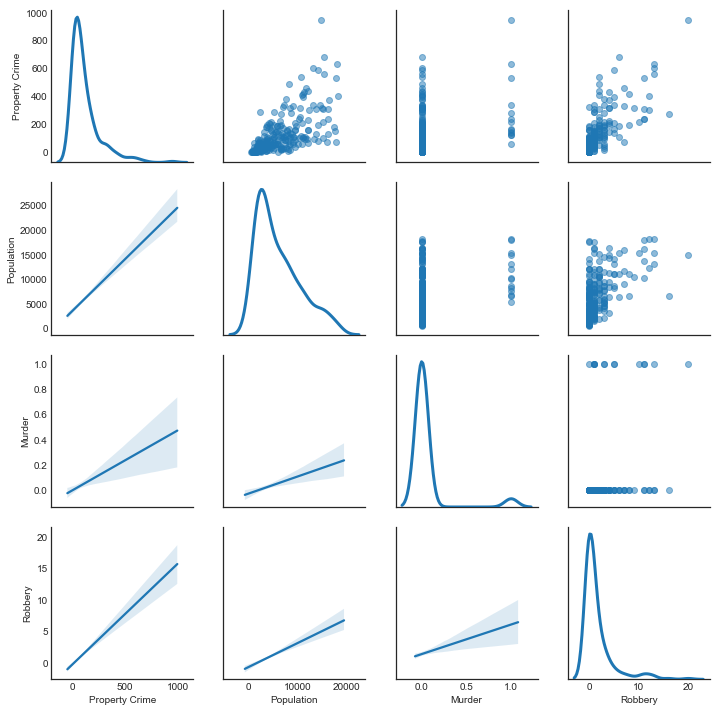

In [1062]:
#Plot the relationships between variables
sns.set_style("white")

#Conisder only the vairables suitable for the model
dfcont = fbiraw_t3[['Property Crime','Population','Murder','Robbery']]

# Scatterplot matrix.
g = sns.PairGrid(dfcont, diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

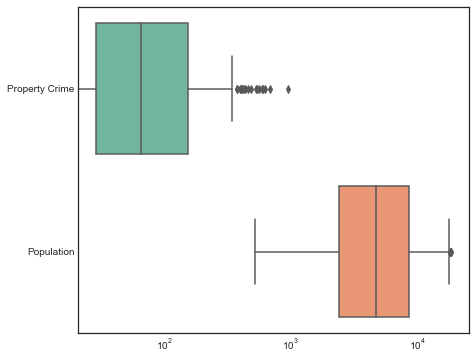

In [1063]:
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Define the variables that are going to be plot
df_long = fbiraw_t3[['Property Crime', 'Population']]

#Boxplot vairables
ax = sns.boxplot(data=df_long, orient="h", palette="Set2")

In [1064]:
#Create the new feature Population2

fbiraw_t3['Population2'] = fbiraw_t3['Population']*fbiraw_t3['Population']

In [1065]:
#Convert Robbery into a categorical feature

fbiraw_t3.loc[fbiraw_t3['Robbery'] > 0, 'Robbery'] = 1

In [1066]:
#Convert Murder into a categorical feature

fbiraw_t3.loc[fbiraw_t3['Murder'] > 0, 'Murder'] = 1

In [1067]:
#Transform dataset into final dataset with features

fbidata = fbiraw_t3[['Property Crime','City','Population', 'Population2','Murder','Robbery']]
fbidata.head()

,Property Crime,City,Population,Population2,Murder,Robbery
0,12.0,Adams Village,1861.0,3463321.0,0.0,0.0
1,24.0,Addison Town and Village,2577.0,6640929.0,0.0,0.0
2,16.0,Akron Village,2846.0,8099716.0,0.0,0.0
3,223.0,Albion Village,6388.0,40806544.0,0.0,1.0
4,46.0,Alfred Village,4089.0,16719921.0,0.0,1.0
